https://www.kaggle.com/sobhanmoosavi/us-accidents

In [1]:
import dask.dataframe as dd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
import datetime
import json

In [2]:
project_root = Path('/home/hayden/proj/ml/traffic_accidents')
data_csv = Path(project_root, 'data', 'US_Accidents_Dec19.csv')

In [3]:
df = dd.read_csv(data_csv)

/home/hayden/anaconda3/envs/traffic/lib/python3.8/site-packages/fsspec/implementations/local.py:29: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  warnings.warn(


In [4]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
# zip_code.txt is a new-line separated list of the Chicago zip codes. If I filter the data by state == IL and city == Chicago, I get way more records than this.
# I'm explicit about the zip code to make sure I'm getting records that are truly from within the Chicago city limits. Additionally, I've created a mapping from
# zip code to city region (North, Northwest, West, Southwest, South, Far South, Central).
with open('./data/chicago/zip_codes.txt') as f:
    chicago_zip_codes = f.read().splitlines()

# First, remove any zip code extension (only use the first 5 digits).
df['Zipcode'] = df['Zipcode'].str[0:5]

# Create a new dataframe with all the records from Chicago zip codes.
chicago_df = df.loc[df['Zipcode'].isin(chicago_zip_codes)].set_index('ID')

# With this smaller dataset, we should be able to go back to using a regular Pandas dataframe (it should fit in memory).
chicago_df = chicago_df.compute()
print('# Chicago accidents: {}.'.format(len(chicago_df.index)))

# Confirm that the resulting dataframe is in fact a Pandas dataframe.
print(type(chicago_df))

# Drop the columns we don't care about.
columns_to_drop = ['Source',
                   'TMC',
                   'End_Lat',
                   'End_Lng',
                   'Number',
                   'City',
                   'County',
                   'State',
                   'Country',
                   'Timezone',
                   'Airport_Code',
                   'Weather_Timestamp',
                   'Temperature(F)',
                   'Wind_Chill(F)',
                   'Humidity(%)',
                   'Pressure(in)',
                   'Visibility(mi)',
                   'Wind_Direction',
                   'Wind_Speed(mph)',
                   'Precipitation(in)',
                   'Amenity',
                   'Civil_Twilight',
                   'Nautical_Twilight',
                   'Astronomical_Twilight']
chicago_df.drop(columns=columns_to_drop, inplace=True)

# Delete the original dataframe
del df

# Chicago accidents: 15950.
<class 'pandas.core.frame.DataFrame'>


In [6]:
# Make all the column names lower case
chicago_df.columns = map(str.lower, chicago_df.columns)

# Let's get an idea of which columns have NaNs and how many.
print(chicago_df.isna().sum())

# If we want to fix the NaNs in a weather_condition column, we could find other accidents on or around the same day and use those conditions. For now, since there
# are so few NaNs (15), let's just drop those records.
chicago_df.dropna(inplace=True)

# Convert the start_time and end_time columns, which are strings, to the datetime type
chicago_df['start_time'] =  pd.to_datetime(chicago_df['start_time'], format='%Y-%m-%d %H:%M:%S')
chicago_df['end_time'] =  pd.to_datetime(chicago_df['end_time'], format='%Y-%m-%d %H:%M:%S')

# Create a new column, duration, which is the difference between the end_time and start_time columns in minutes
chicago_df['duration'] = chicago_df['end_time'] - chicago_df['start_time']
chicago_df['duration'] = chicago_df['duration'].dt.total_seconds() / 60 # TODO: see if we can combine these two lines
print(chicago_df['duration'].head())

# Check for accidents with <= 0 seconds duration.
assert(len(chicago_df.loc[chicago_df['duration'] <= 0]) == 0)

# Make the street column lower case
chicago_df['street'] = chicago_df['street'].str.lower()

# Check the streets of each accident for references to highways/expressways/interstates. Add a column indicating if the accident took place on a highway
# using this information.
highway_strings = '|'.join(['expy',
                            'us-',
                            'il-',
                            'dan ryan',
                            'kennedy',
                            'i-',
                            'jane addams',
                            'eisenhower',
                            'stevenson',
                            'lake shore',
                            'tollway',
                            'state route'])
chicago_df['highway'] = np.where(chicago_df['street'].str.contains(highway_strings, regex=True), 1, 0)

# TODO: Check this out for ideas about how to handle date and time features:
# https://datascience.stackexchange.com/questions/17759/encoding-features-like-month-and-hour-as-categorial-or-numeric
# Probably go for quarter, weekend, time of day (morning, day, afternoon, evening, night). Ignore year, I think. Keep
# using the sunset/sunrise based Day/Night categorization, as that gives us data about the light level outside, not just time,
# since the level of light at different times varies throughout the year.

def is_weekend(start_time):
    # Returns 1 if the day is Saturday, Sunday, or Friday after 5PM, 0 otherwise.
    return 1 if start_time.dayofweek in [5, 6] or (start_time.dayofweek == 4 and start_time.hour >= 17) else 0
    

def time_of_day_bucket(start_time):
    if 0 <= start_time.hour < 5:
        return 'early_morning'
    elif 5 <= start_time.hour < 12:
        return 'morning'
    elif 12 <= start_time.hour < 17:
        return 'afternoon'
    elif 17 <= start_time.hour < 24:
        return 'evening'
    else:
        raise Exception('there\'s a bug')

# Add day_of_week, month, and year columns.
chicago_df['quarter'] = chicago_df['start_time'].dt.quarter
chicago_df['weekend'] = chicago_df['start_time'].apply(lambda x: is_weekend(x))
chicago_df['tod_bucket'] = chicago_df['start_time'].apply(lambda x: time_of_day_bucket(x))

# Add a region column, based on the zip_to_region.json file.
with open('./data/chicago/zip_to_region.json') as f:
    zip_to_region = json.load(f)
    
chicago_df['region'] = chicago_df['zipcode'].apply(lambda x: zip_to_region[x])

# One-hot encode quarter, weekend, tod_bucket, and region.
# chicago_df = pd.get_dummies(chicago_df, columns=['quarter', 'tod_bucket', 'region', 'side'])

# Change the sunrise_sunset column to a 'daylight' column.
chicago_df['daylight'] = np.where(chicago_df['sunrise_sunset'] == 'Day', 1, 0)

# Encode different weather conditions in new columns.
cloudy_conditions = [
    'Cloudy', 'Mostly Cloudy', 'Cloudy / Windy', 'Light Rain',
    'Light Rain with Thunder', 'Drizzle', 'Light Snow', 'Rain', 'T-Storm',
    'Rain / Windy', 'Overcast', 'Light Drizzle', 'Light Freezing Drizzle',
    'Light Freezing Rain', 'Snow', 'Light Ice Pellets', 'Light Freezing Fog',
    'Blowing Snow', 'Heavy Rain', 'Thunderstorm',
    'Light Thunderstorms and Rain', 'Heavy Thunderstorms and Rain',
    'Thunderstorms and Rain', 'Heavy Snow', 'Light Snow / Windy',
    'Mostly Cloudy / Windy', 'Light Rain / Windy', 'Wintry Mix', 'Mist',
    'Wintry Mix / Windy', 'Heavy T-Storm', 'Thunder', 'Snow and Sleet'
]

rainy_conditions = [
    'Light Rain', 'Light Rain with Thunder', 'Drizzle', 'Rain', 'Rain / Windy',
    'Light Drizzle', 'Light Freezing Drizzle', 'Light Freezing Rain',
    'Light Thunderstorms and Rain', 'Heavy Thunderstorms and Rain',
    'Thunderstorms and Rain', 'Light Rain / Windy', 'Mist'
]

snow_and_ice_conditions = [
    'Light Freezing Drizzle', 'Light Freezing Rain', 'Light Snow', 'Snow',
    'Light Ice Pellets', 'Blowing Snow', 'Heavy Snow', 'Light Snow / Windy',
    'Wintry Mix', 'Wintry Mix / Windy', 'Snow and Sleet'
]

stormy_conditions = [
    'T-Storm', 'Thunderstorm', 'Light Thunderstorms and Rain',
    'Heavy Thunderstorms and Rain', 'Thunderstorms and Rain', 'Heavy T-Storm',
    'Thunder'
]

foglike_conditions = ['Haze', 'Fog', 'Light Freezing Fog', 'Smoke']

windy_conditions = [
    'Light Snow / Windy', 'Partly Cloudy / Windy', 'Mostly Cloudy / Windy',
    'Light Rain / Windy', 'Wintry Mix / Windy'
]

chicago_df['cloudy'] = np.where(chicago_df['weather_condition'].isin(cloudy_conditions), 1, 0)
chicago_df['rainy'] = np.where(chicago_df['weather_condition'].isin(rainy_conditions), 1, 0)
chicago_df['snow_or_ice'] = np.where(chicago_df['weather_condition'].isin(snow_and_ice_conditions), 1, 0)
chicago_df['stormy'] = np.where(chicago_df['weather_condition'].isin(stormy_conditions), 1, 0)
chicago_df['foglike'] = np.where(chicago_df['weather_condition'].isin(foglike_conditions), 1, 0)
chicago_df['windy'] = np.where(chicago_df['weather_condition'].isin(windy_conditions), 1, 0)

print(chicago_df.columns)
chicago_df.head()

# TODO: holiday columns? I would expect longer durations on NYE, Christmas, etc.

severity              0
start_time            0
end_time              0
start_lat             0
start_lng             0
distance(mi)          0
description           0
street                0
side                  0
zipcode               0
weather_condition    15
bump                  0
crossing              0
give_way              0
junction              0
no_exit               0
railway               0
roundabout            0
station               0
stop                  0
traffic_calming       0
traffic_signal        0
turning_loop          0
sunrise_sunset        0
dtype: int64
ID
A-1002153    44.716667
A-1002156    83.050000
A-1002158    74.050000
A-1002166    60.416667
A-1002167    61.850000
Name: duration, dtype: float64
Index(['severity', 'start_time', 'end_time', 'start_lat', 'start_lng',
       'distance(mi)', 'description', 'street', 'zipcode', 'weather_condition',
       'bump', 'crossing', 'give_way', 'junction', 'no_exit', 'railway',
       'roundabout', 'station', 'stop'

,severity,start_time,end_time,start_lat,start_lng,distance(mi),description,street,zipcode,weather_condition,...,region_West,side_L,side_R,daylight,cloudy,rainy,snow_or_ice,stormy,foglike,windy
ID,,,,,,,,,,,,,,,,,,,,,
A-1002153,3,2019-04-14 23:58:01,2019-04-15 00:42:44,41.984261,-87.852516,0.00,Earlier accident on I-90 Westbound at I-190.,i-90 w,60631,Cloudy,...,0,0,1,0,1,0,0,0,0,0
A-1002156,2,2019-04-15 04:10:04,2019-04-15 05:33:07,41.892769,-87.648155,0.00,Restrictions due to accident on I-90 Kennedy E...,w ohio st,60642,Mostly Cloudy,...,0,0,1,0,1,0,0,0,0,0
A-1002158,2,2019-04-15 04:18:49,2019-04-15 05:32:52,41.847210,-87.642113,0.73,Accident on exit ramp from I-55 Northbound at ...,dan ryan expy s,60616,Mostly Cloudy,...,0,0,1,0,1,0,0,0,0,0
A-1002166,2,2019-04-15 05:26:13,2019-04-15 06:26:38,41.875191,-87.666618,0.00,Accident on Ashland Ave at Congress Pkwy.,s ashland ave,60607,Fair,...,0,1,0,0,0,0,0,0,0,0
A-1002167,2,2019-04-15 05:34:10,2019-04-15 06:36:01,41.872219,-87.744797,0.00,Accident on IL-50 Cicero Ave at Flournoy St.,s cicero ave,60644,Fair,...,1,0,1,0,0,0,0,0,0,0


In [ ]:
chicago_df.sort_values(by=['duration'], ascending=False)[['start_time', 'end_time', 'duration', 'region_West', 'region_South', 'region_Southwest', 'region_North', 'region_Northwest', 'region_Far South']][0:20]

In [26]:
print(chicago_df.loc['A-2494334']['description'])

Ramp closed to I-90/I-94 Eastbound and W Taylor St - Road closed due to accident. Roadwork.


In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

# x = chicago_df[['bump', 'crossing', 'give_way', 'junction', 'no_exit', 'railway',
#        'roundabout', 'station', 'stop', 'traffic_calming', 'traffic_signal',
#        'turning_loop', 'highway', 'weekend',
#        'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4',
#        'tod_bucket_afternoon', 'tod_bucket_early_morning',
#        'tod_bucket_evening', 'tod_bucket_morning', 'region_Central',
#        'region_Far South', 'region_North', 'region_Northwest', 'region_South',
#        'region_Southwest', 'region_West', 'side_L', 'side_R', 'daylight',
#        'cloudy', 'rainy', 'snow_or_ice', 'stormy', 'foglike', 'windy']].to_numpy()
x = chicago_df['highway'].to_numpy().reshape(-1, 1)
y = chicago_df['severity'].to_numpy()

# Create training and testing splits.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

regr = GradientBoostingRegressor()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
print(mean_squared_error(y_test, regr.predict(x_test)))

0.33148500590468427


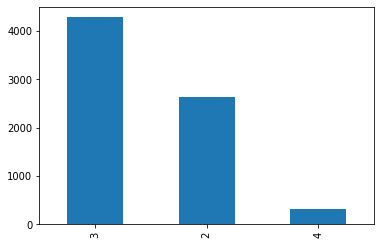

In [26]:
chicago_df[chicago_df['highway'] == 1]['severity'].value_counts().plot(kind='bar');

['Cloudy' 'Mostly Cloudy' 'Fair' 'Light Rain' 'Cloudy / Windy'
 'Fair / Windy' 'Partly Cloudy' 'Light Rain with Thunder' 'Drizzle'
 'Light Snow' 'Rain' 'T-Storm' 'Rain / Windy' 'Clear' 'Overcast'
 'Light Drizzle' 'Haze' 'Scattered Clouds' 'Fog' 'Light Freezing Drizzle'
 'Light Freezing Rain' 'Snow' 'Light Ice Pellets' 'Light Freezing Fog'
 'Blowing Snow' 'Heavy Rain' 'Thunderstorm' 'Light Thunderstorms and Rain'
 'Heavy Thunderstorms and Rain' nan 'Thunderstorms and Rain' 'Smoke'
 'Heavy Snow' 'Light Snow / Windy' 'Partly Cloudy / Windy'
 'Mostly Cloudy / Windy' 'Light Rain / Windy' 'Wintry Mix' 'Mist'
 'Wintry Mix / Windy' 'Heavy T-Storm' 'Thunder' 'Snow and Sleet']
# possible weather conditions: 43


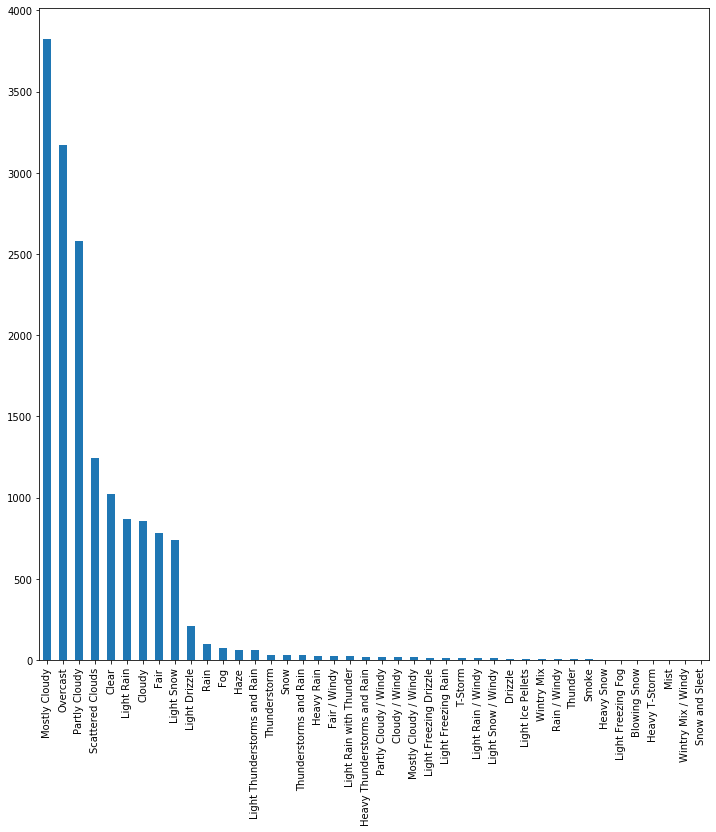

In [13]:
# Let's see what the different values for the weather_condition column are.
possible_weather_conditions = chicago_df['weather_condition'].unique()
print(possible_weather_conditions)
print('# possible weather conditions: {}'.format(len(possible_weather_conditions)))

# And let's see a bar graph of accidents for each category of weather condition.
plt.figure(figsize=(12, 12))
chicago_df['weather_condition'].value_counts().plot(kind='bar');

From the above graph, we can see that most categories for weather_condition are very infrequent. We can simplify these categories a bit. I would transform this column into multiple boolean columns: cloudy, partly_cloudy, rain, snow, haze/fog/mist/smoke, storm.

In [33]:
# Read in the Cook County map file
city_map = gpd.read_file('./data/chicago/shapefiles/tl_2018_17031_addrfeat.shp')

In [35]:
# Learned how to do this from: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972.
# Read more about Coordinate Reference System (CRS) here: https://geopandas.org/projections.html.
# Since we have GPS latitude and longitude values, we need to use the CRS WGS84: http://mapref.org/WGS84-theCRSofGPS.html.
# According to the geopandas documentation mentioned above, the corresponding "authority code" for this CRS is "EPSG:4326".
crs = {'init': 'EPSG:4326'}

# TODO: Plot points of accidents on the map, colored by region.
# TODO: Bar plot of accidents on highways and not on highways.

# Create a list of starting points for the accidents based on the latitude and longitude values.
accident_start_pts = [Point(xy) for xy in zip(chicago_df['start_lng'], chicago_df['start_lat'])]
print(len(accident_start_pts))
geo_df = gpd.GeoDataFrame(city_map, crs=crs, geometry=accident_start_pts)
geo_df.head()

15935


ValueError: Length of values does not match length of index

NameError: name 'county_map' is not defined

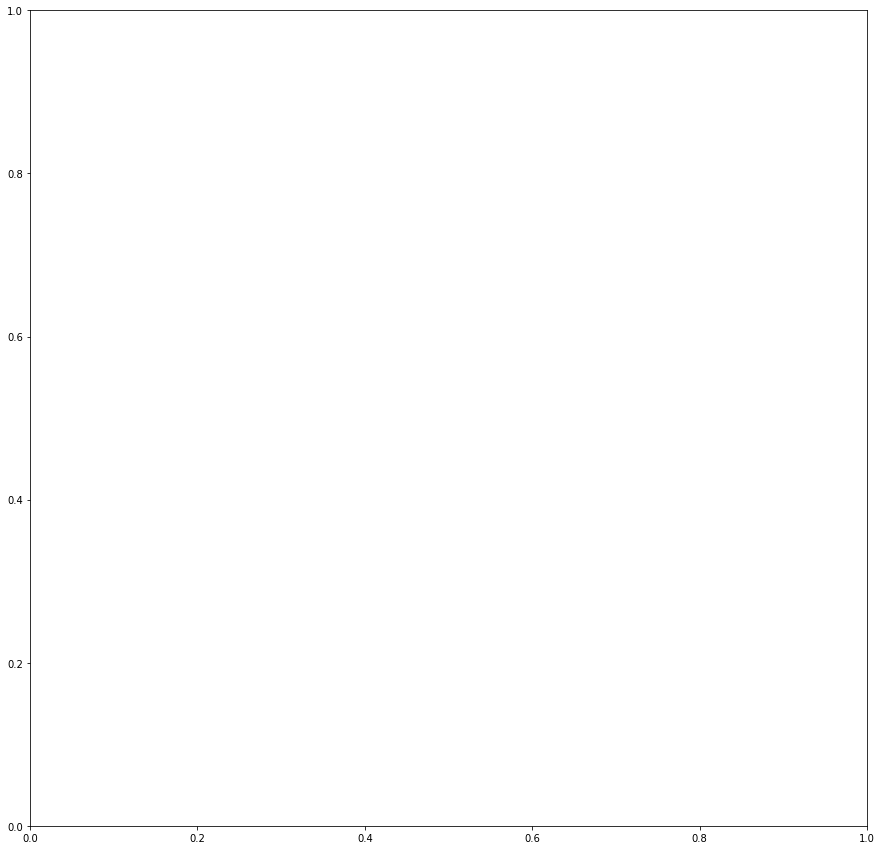

In [31]:
# Plot the map with the accident starting points.
fig, ax = plt.subplots(figsize=(15, 15))
county_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(column='region_West', ax=ax)

In [171]:
# Compute the average duration of accidents.
print(cook_county_df['duration'].mean())

# Compute the mean duration of accidents grouped by severity level. 1 is the least impact on traffic, 4 is the most impact on traffic.
# Intuitively, we would expect the duration to increase with increaaatsing severity level.
severity_counts = cook_county_df.groupby('severity')['duration'].mean(numeric_only=False).sort_index()
severity_counts.head()

# If we wish to create a model that predicts the duration of an accident based on some of these variables, we shouldn't use variables
# that are only known after the accident has been resolved. That includes severity. We should try to be able to predict duration
# just using data that would be available as soon as an accident is reported.
# Variables to consider:
#     - Description (will need to generate new columns from textual analysis of this column)
#     - Temperature
#     - Wind chill
#     - Humidity
#     - Pressure
#     - Visibility
#     - Wind speed
#     - Precipitation
#     - Weather condition
#     - POI stuff
#     - Time of day stuff
#         - Day of week
#         - Month of year
#         - Day/Night (see twilight columns)
#         - Year
#     - At/near intersection

0 days 02:39:57.469133


severity
1   00:42:25.833333
2   02:18:49.298855
3   02:38:56.150937
4   07:07:13.512252
Name: duration, dtype: timedelta64[ns]

In [9]:
# Let's add day_of_week, month, and year columns.
cook_county_df['day_of_week'] = cook_county_df['start_time'].dt.dayofweek
cook_county_df['month'] = cook_county_df['start_time'].dt.month
cook_county_df['year'] = cook_county_df['start_time'].dt.year
cook_county_df.head()

,source,tmc,severity,start_time,end_time,start_lat,start_lng,end_lat,end_lng,distance(mi),...,traffic_signal,turning_loop,sunrise_sunset,civil_twilight,nautical_twilight,astronomical_twilight,duration,day_of_week,month,year
ID,,,,,,,,,,,,,,,,,,,,,
A-1000577,MapQuest,201.0,3,2019-04-14 08:02:43,2019-04-14 09:01:25,41.601883,-87.708763,NaN,NaN,0.0,...,False,False,Day,Day,Day,Day,00:58:42,6,4,2019
A-1000578,MapQuest,201.0,3,2019-04-14 08:47:41,2019-04-14 09:17:10,41.618546,-87.691154,NaN,NaN,0.0,...,False,False,Day,Day,Day,Day,00:29:29,6,4,2019
A-1000582,MapQuest,241.0,3,2019-04-14 10:53:31,2019-04-14 11:23:01,41.578251,-87.660751,NaN,NaN,0.0,...,False,False,Day,Day,Day,Day,00:29:30,6,4,2019
A-1002153,MapQuest,343.0,3,2019-04-14 23:58:01,2019-04-15 00:42:44,41.984261,-87.852516,NaN,NaN,0.0,...,False,False,Night,Night,Night,Night,00:44:43,6,4,2019
A-1002156,MapQuest,201.0,2,2019-04-15 04:10:04,2019-04-15 05:33:07,41.892769,-87.648155,NaN,NaN,0.0,...,False,False,Night,Night,Night,Night,01:23:03,0,4,2019


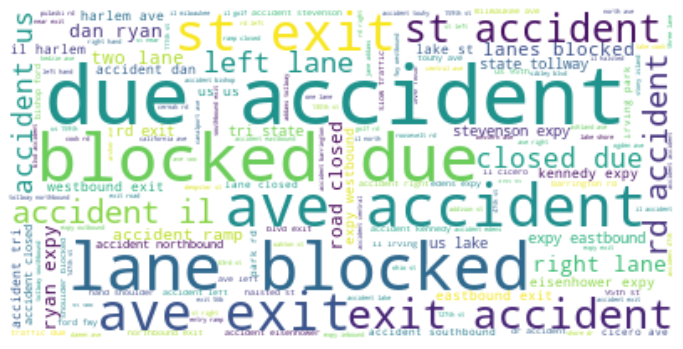

In [164]:
# Approach taken from here: https://www.datacamp.com/community/tutorials/wordcloud-python.
# Create a string of all words in all descriptions separated by spaces
descs = ' '.join(desc.lower() for desc in cook_county_df['description'])

# Create a wordcloud, ignoring common stop words.
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(descs)

# Show the cloud.
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The presence of the word "block" might correlate with duration / severity, i.e. the road is blocked. However, that's only something we can know after an accident is investigated, so it's not useful as a feature for immediate prediction of the duration.

In [11]:
# TODO: Choose initial set of features, clean NaNs, and perform PCA. Also learn how to do regression with categorical variables.
# Encoding categorical variables: https://pbpython.com/categorical-encoding.html
cook_county_df.columns

Index(['source', 'tmc', 'severity', 'start_time', 'end_time', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'distance(mi)', 'description',
       'number', 'street', 'side', 'city', 'county', 'state', 'zipcode',
       'country', 'timezone', 'airport_code', 'weather_timestamp',
       'temperature(f)', 'wind_chill(f)', 'humidity(%)', 'pressure(in)',
       'visibility(mi)', 'wind_direction', 'wind_speed(mph)',
       'precipitation(in)', 'weather_condition', 'amenity', 'bump', 'crossing',
       'give_way', 'junction', 'no_exit', 'railway', 'roundabout', 'station',
       'stop', 'traffic_calming', 'traffic_signal', 'turning_loop',
       'sunrise_sunset', 'civil_twilight', 'nautical_twilight',
       'astronomical_twilight', 'duration', 'day_of_week', 'month', 'year'],
      dtype='object')

In [ ]:
# Feature selection:
# Start lat
# Start lng
# ^ alternatively, community area or some other spacial clustering --> zipcode!
# Highway or not --> can do this by analyzing the descriptions, I think
# side (of road)
# Various weather conditions (need to create dummy variables for these)
# Bump
# Crossing
# give_way
# junction
# no_exit
# railway
# station
# stop
# traffic_calming
# traffic_signal
# turning_loop
# day/night according to the sunrise/sunset column (can experiment with other columns conveying daynight, like the twilight columns)